In [11]:
import torch
import logging
import sys

from model.vision_transformer_utils import (
    WarmupCosineSchedule,
    CosineWDSchedule)
from model.vision_transformer_utils import trunc_normal_, init_opt, apply_masks_targets
from model.ijepa_utils import AverageMeter
from model.vision_transformer import VisionTransformer, VisionTransformerPredictor

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger()



def load_checkpoint(
    device,
    r_path,
    encoder,
    predictor,
    target_encoder,
    opt,
    scaler,
):
    try:
        checkpoint = torch.load(r_path, map_location=torch.device('cpu'))
        epoch = checkpoint['epoch']

        # -- loading encoder
        pretrained_dict = checkpoint['encoder']
        msg = encoder.load_state_dict(pretrained_dict)
        logger.info(f'loaded pretrained encoder from epoch {epoch} with msg: {msg}')

        # -- loading predictor
        pretrained_dict = checkpoint['predictor']
        msg = predictor.load_state_dict(pretrained_dict)
        logger.info(f'loaded pretrained encoder from epoch {epoch} with msg: {msg}')

        # -- loading target_encoder
        if target_encoder is not None:
            print(list(checkpoint.keys()))
            pretrained_dict = checkpoint['target_encoder']
            msg = target_encoder.load_state_dict(pretrained_dict)
            logger.info(f'loaded pretrained encoder from epoch {epoch} with msg: {msg}')

        # -- loading optimizer
        if opt is not None:
            opt.load_state_dict(checkpoint['opt'])
        if scaler is not None:
            scaler.load_state_dict(checkpoint['scaler'])
        logger.info(f'loaded optimizers from epoch {epoch}')
        logger.info(f'read-path: {r_path}')
        del checkpoint

    except Exception as e:
        logger.info(f'Encountered exception when loading checkpoint {e}')
        epoch = 0

    return encoder, predictor, target_encoder, opt, scaler, epoch


In [12]:
load_model=True
import time
import yaml
sys.path.append('.')
sys.path.append('..')
from lib.dataloader import get_dataloader


# start_epoch = args.start_epoch
# num_epochs = args.num_epochs

args = {"data_dir": r"data", "dataset": "NYCTaxi", "batch_size": 32, "test_batch_size": 32, "rows": 20, "cols": 10, "num_epochs": 100}
dataloader = get_dataloader(
    data_dir=args['data_dir'], 
    dataset=args['dataset'], 
    batch_size=args['batch_size'], 
    test_batch_size=args['test_batch_size'],
    scalar_type='Standard'
)
train_loader = dataloader['train']
test_loader = dataloader['test']
val_loader = dataloader['val']


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = VisionTransformer(
        img_size=(args["rows"], args["cols"]),
        patch_size=1,
        in_chans=2,
        embed_dim=64,
        predictor_embed_dim=None,
        depth=1,
        predictor_depth=None,
        num_heads=1,
        mlp_ratio=4,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.2,
        drop_path_rate=0.1,
        norm_layer=torch.nn.LayerNorm,
        init_std=0.02
    )
predictor = VisionTransformerPredictor(
    img_size=(args["rows"], args["cols"]),
    embed_dim=64,
    predictor_embed_dim=64//2,
    depth=1,
    num_heads=1,
    mlp_ratio=4,
    qkv_bias=True,
    qk_scale=None,
    drop_rate=0.0,
    attn_drop_rate=0.2,
    drop_path_rate=0.1,
    norm_layer=torch.nn.LayerNorm,
    init_std=0.02
)

import copy
target_encoder = copy.deepcopy(encoder)

wd = 0.04
final_wd = 0.4
start_lr = 0.0002
final_lr = 1.0e-06
lr = 0.001
ipe = len(train_loader)
warmup = 40
ipe_scale = 1.0
use_bfloat16 = True
optimizer, scaler, scheduler, wd_scheduler = init_opt(
        encoder=encoder,
        predictor=predictor,
        wd=wd,
        final_wd=final_wd,
        start_lr=start_lr,
        ref_lr=lr,
        final_lr=final_lr,
        iterations_per_epoch=ipe,
        warmup=warmup,
        num_epochs=args["num_epochs"],
        ipe_scale=ipe_scale,
        use_bfloat16=use_bfloat16)

ema = [0.996, 1.0]
ipe = len(train_loader)
ipe_scale = 1.0
momentum_scheduler = (ema[0] + i*(ema[1]-ema[0])/(ipe*args["num_epochs"]*ipe_scale)
                        for i in range(int(ipe*args["num_epochs"]*ipe_scale)+1))



data['x_train'].shape:  (1912, 35, 200, 2) (1912, 1, 200, 2)
INFO:root:Using AdamW


In [13]:
load_path = r"D:\omer\ST-SSL\logs\singleBLK\jepa-ep90.pth.tar"

if load_model:
    encoder, predictor, target_encoder, optimizer, scaler, start_epoch = load_checkpoint(
        device=device,
        r_path=load_path,
        encoder=encoder,
        predictor=predictor,
        target_encoder=target_encoder,
        opt=optimizer,
        scaler=scaler)
    for _ in range(start_epoch*ipe):
        scheduler.step()
        wd_scheduler.step()
        next(momentum_scheduler)
        

INFO:root:loaded pretrained encoder from epoch 89 with msg: <All keys matched successfully>
INFO:root:loaded pretrained encoder from epoch 89 with msg: <All keys matched successfully>
['encoder', 'predictor', 'target_encoder', 'opt', 'scaler', 'epoch', 'loss', 'batch_size', 'world_size', 'lr']
INFO:root:loaded pretrained encoder from epoch 89 with msg: <All keys matched successfully>
INFO:root:loaded optimizers from epoch 89
INFO:root:read-path: D:\omer\ST-SSL\logs\singleBLK\jepa-ep90.pth.tar


In [14]:
def generateMasks(data):
    """
    :param data: tensor of shape [B, R, C, D]
    :returns: (data, 1x masks_enc, 4x masks_pred)
    """
    B, R, C, D = data.size()

    # Initialize masks
    masks_enc = torch.zeros(B, R, C, dtype=torch.uint8)
    masks_pred = torch.zeros(4, B, R, C, dtype=torch.uint8)

    ## select deltas before sample loop. 
    ## grid_size: 20x10
    delta_h_ctxt = torch.randint(6, 10, (1,))        ## low (inclusive), high (exclusive)
    delta_w_ctxt = torch.randint(4, 6, (1,))  
    delta_h_trgt = torch.randint(4, 8, (1,))  
    delta_w_trgt = torch.randint(2, 4, (1,))  
    
    for b in range(B):
        # Select h1, w1 for the encoding mask with constraints
        h1 = torch.randint(0, R, (1,))
        if h1 + delta_h_ctxt > R:
            h1 = R - delta_h_ctxt
        w1 = torch.randint(0, C, (1,))
        if w1 + delta_w_ctxt > C:
            w1 = C - delta_w_ctxt
        
        # Set the encoding mask
        masks_enc[b, h1:h1+delta_h_ctxt, w1:w1+delta_w_ctxt] = 1

        # Generate four prediction masks (can be overlapping with each other, but not with context mask)
        for i in range(4):
            n=0
            while True:
                if n>2000:
                    print(f"cant find valid mask n={n}, stuck...")
                # Smaller random sizes for prediction masks
                h1 = torch.randint(0, R, (1,))
                if h1 + delta_h_trgt > R:
                    h1 = R - delta_h_trgt
                w1 = torch.randint(0, C, (1,))
                if w1 + delta_w_trgt > C:
                    w1 = C - delta_w_trgt

                # Create a temporary mask to check overlap
                temp_mask = torch.zeros(R, C, dtype=torch.bool)
                temp_mask[h1:h1+delta_h_trgt, w1:w1+delta_w_trgt] = 1

                # Check if it overlaps with the encoding mask
                if torch.any(masks_enc[b] & temp_mask):
                    n+=1
                    continue  # Overlaps, try again

                # No overlap, set this mask
                masks_pred[i, b] = temp_mask
                break

    return (data, masks_enc, masks_pred.transpose(0, 1))  


In [15]:
# import torch.nn.functional as F

# def evaluate_model(data_loader, encoder, predictor, target_encoder, device):
#     """
#     Perform evaluation of the model on the given data loader.
    
#     Args:
#         data_loader (DataLoader): The data loader for the dataset to evaluate.
#         encoder (nn.Module): The encoder model.
#         predictor (nn.Module): The predictor model.
#         target_encoder (nn.Module): The target encoder model.
#         device (str): The device to run the evaluation on, e.g., 'cuda' or 'cpu'.
    
#     Returns:
#         float: The average loss over the evaluation dataset.
#     """
#     encoder.eval().to(device)
#     predictor.eval().to(device)
#     target_encoder.eval().to(device)
#     loss_meter = AverageMeter()
    
#     with torch.no_grad():
#         for data, _ in data_loader:
#             data = data[:, 0, :, :].squeeze(1)  # Simplify data handling for evaluation
#             B, N, D = data.size()
#             data = data.view(B, args["rows"], args["cols"], D).to(device)
#             imgs, masks_enc, masks_pred = generateMasks(data)
#             imgs = imgs.permute(0, 3, 1, 2)  # [B, D, R, C]
#             masks_pred = masks_pred.flatten(2)  # [B, 4, R*C]
#             masks_enc = masks_enc.flatten(1).unsqueeze(1)  # [B, 1, R*C]
            
#             """ see whole image as context """
#             masks_enc=torch.ones_like(masks_enc)


#             # Forward pass through the models
#             def forward_target():    ## mask target tokens after encoding
#                 with torch.no_grad():  #sg
#                     h = target_encoder(imgs, masks=None)  ## VisionTransformer  masks_enc=None
#                     h = F.layer_norm(h, (h.size(-1),))  # normalize over feature-dim
#                     B = len(h)
#                     h = apply_masks_targets(h, masks_pred)
#                     return h

#             def forward_context():    ## mask context tokens before encoding
                
#                 z = encoder(imgs, masks=masks_enc)  ## VisionTransformer
#                 """input to predictor is z: [32, 45, 256]"""
#                 z = predictor(z, masks_enc, masks_pred)   ## VisionTransformerPredictor
#                 return z
#             h = forward_target()  # Target encoder forward pass
#             z = forward_context()  # Context encoder forward pass
            
#             # Compute loss
#             loss = F.smooth_l1_loss(z, h)
#             loss_meter.update(loss.item(), B)
    
#     return loss_meter.avg

# loss = evaluate_model(val_loader, encoder, predictor, target_encoder, 'cuda')
# print("Validation Loss: ", loss)


In [117]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = VisionTransformer(
        img_size=(args["rows"], args["cols"]),
        patch_size=1,
        in_chans=2,
        embed_dim=256,
        predictor_embed_dim=None,
        depth=6,
        predictor_depth=None,
        num_heads=1,
        mlp_ratio=4,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.2,
        drop_path_rate=0.1,
        norm_layer=torch.nn.LayerNorm,
        init_std=0.02
    )
predictor = VisionTransformerPredictor(
    img_size=(args["rows"], args["cols"]),
    embed_dim=256,
    predictor_embed_dim=256//2,
    depth=6,
    num_heads=1,
    mlp_ratio=4,
    qkv_bias=True,
    qk_scale=None,
    drop_rate=0.0,
    attn_drop_rate=0.2,
    drop_path_rate=0.1,
    norm_layer=torch.nn.LayerNorm,
    init_std=0.02
)

import copy
target_encoder = copy.deepcopy(encoder)


In [118]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = VisionTransformer(
        img_size=(args["rows"], args["cols"]),
        patch_size=1,
        in_chans=2,
        embed_dim=256,
        predictor_embed_dim=None,
        depth=6,
        predictor_depth=None,
        num_heads=1,
        mlp_ratio=4,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.2,
        drop_path_rate=0.1,
        norm_layer=torch.nn.LayerNorm,
        init_std=0.02
    )
predictor = VisionTransformerPredictor(
    img_size=(args["rows"], args["cols"]),
    embed_dim=256,
    predictor_embed_dim=256//2,
    depth=6,
    num_heads=1,
    mlp_ratio=4,
    qkv_bias=True,
    qk_scale=None,
    drop_rate=0.0,
    attn_drop_rate=0.2,
    drop_path_rate=0.1,
    norm_layer=torch.nn.LayerNorm,
    init_std=0.02
)

import copy
target_encoder = copy.deepcopy(encoder)


load_path = r"D:\omer\ST-SSL\logs\pretrain_logs\jepa-ep50.pth.tar"

if load_model:
    encoder, predictor, target_encoder, optimizer, scaler, start_epoch = load_checkpoint(
        device=device,
        r_path=load_path,
        encoder=encoder,
        predictor=predictor,
        target_encoder=target_encoder,
        opt=optimizer,
        scaler=scaler)
    for _ in range(start_epoch*ipe):
        scheduler.step()
        wd_scheduler.step()

        # next(momentum_scheduler)
## just get the attention maps from the context_encoder (input whole image)
encoder.eval().to(device)
predictor.eval().to(device)
target_encoder.eval().to(device)
with torch.no_grad():
    for i, (data, _) in enumerate(val_loader):
        data = data[:, 0, :, :].squeeze(1)
        B, N, D = data.size()
        data = data.view(B, args["rows"], args["cols"], D).to(device)
        imgs, masks_enc, masks_pred = generateMasks(data)
        imgs = imgs.permute(0, 3, 1, 2)  # [B, D, R, C]
        masks_pred = masks_pred.flatten(2)  # [B, 4, R*C]
        masks_enc = masks_enc.flatten(1).unsqueeze(1)  # [B, 1, R*C]
        
        """ see whole image as context """
        masks_enc=torch.ones_like(masks_enc)
        # masks_enc=torch.zeros_like(masks_enc)
        # masks_enc[:, :, 0:2] = 1
        def forward_context():    ## mask context tokens before encoding
            z, attn_list = encoder(imgs, masks=masks_enc)  ## VisionTransformer
            return z, attn_list
        
        z, attn_list_1 = forward_context()  # Context encoder forward pass
        


INFO:root:loaded pretrained encoder from epoch 49 with msg: <All keys matched successfully>
INFO:root:loaded pretrained encoder from epoch 49 with msg: <All keys matched successfully>
['encoder', 'predictor', 'target_encoder', 'opt', 'scaler', 'epoch', 'loss', 'batch_size', 'world_size', 'lr']
INFO:root:loaded pretrained encoder from epoch 49 with msg: <All keys matched successfully>
INFO:root:Encountered exception when loading checkpoint loaded state dict contains a parameter group that doesn't match the size of optimizer's group


In [120]:
# print(len(attn_list))
a=0
print(attn_list_1[0].shape)
for i in range(7):
    if i == 6:
        attn1 = average_attention[a:a+20,:200]
    else:
        attn1 = attn_list_1[i][0].squeeze(0).softmax(-1).cpu().numpy()[a:a+20,:200]
    print(attn1.shape)

    # avg_attn = torch.tensor(average_attention).softmax(-1).numpy()[100:120,:200]
    # avg_attn = average_attention[0:20,:200]
    import numpy as np
    import plotly.figure_factory as ff

    # Create a heatmap using Plotly, attempting again
    fig = ff.create_annotated_heatmap(
        z=attn1,
        colorscale='Magma',
        showscale=True
    )
    fig.update_layout(
        title='Interactive Attention Matrix Heatmap',
        width=900,
        height=900,
        xaxis=dict(ticks='', side='top'),
        yaxis=dict(ticks='')
    )
    print("\n\ni: ", i)
    fig.show()

torch.Size([32, 1, 200, 200])
(20, 200)


i:  0


(20, 200)


i:  1


(20, 200)


i:  2


(20, 200)


i:  3


(20, 200)


i:  4


(20, 200)


i:  5


(20, 200)


i:  6


(200, 200)


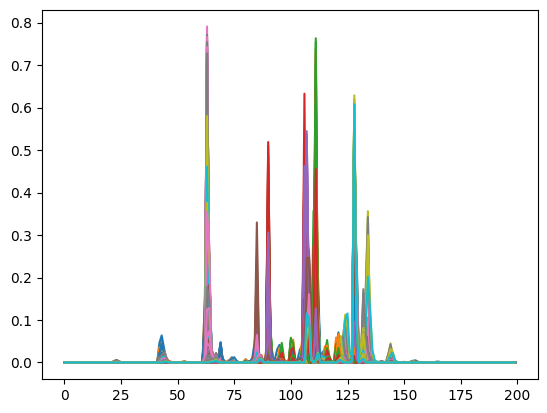

In [115]:
attn1 = attn_list[0][0].squeeze(0).softmax(-1).cpu().numpy().transpose()[:,0:300]
print(attn1.shape)
import matplotlib.pyplot as plt
plt.plot(attn1)

In [122]:
# print(len(attn_list))
a=80
print(attn_list[0].shape)
for i in range(6):
    if i == 6:
        attn1 = average_attention[a:a+20,:200]
    else:
        attn1 = attn_list[i][0].squeeze(0).softmax(-1).cpu().numpy()[a:a+20,:200]
    print(attn1.shape)

    # avg_attn = torch.tensor(average_attention).softmax(-1).numpy()[100:120,:200]
    # avg_attn = average_attention[0:20,:200]
    import numpy as np
    import plotly.figure_factory as ff

    # Create a heatmap using Plotly, attempting again
    fig = ff.create_annotated_heatmap(
        z=attn1,
        colorscale='Magma',
        showscale=True
    )
    fig.update_layout(
        title='Interactive Attention Matrix Heatmap',
        width=900,
        height=900,
        xaxis=dict(ticks='', side='top'),
        yaxis=dict(ticks='')
    )
    print("\n\ni: ", i)
    fig.show()

torch.Size([32, 1, 200, 200])
(20, 200)


i:  0


INFO:root:loaded pretrained encoder from epoch 29 with msg: <All keys matched successfully>
INFO:root:loaded pretrained encoder from epoch 29 with msg: <All keys matched successfully>


['encoder', 'predictor', 'target_encoder', 'opt', 'scaler', 'epoch', 'loss', 'batch_size', 'world_size', 'lr']
INFO:root:loaded pretrained encoder from epoch 29 with msg: <All keys matched successfully>
INFO:root:loaded optimizers from epoch 29
INFO:root:read-path: D:\omer\ST-SSL\logs\singleBLK_try2\jepa-ep30.pth.tar


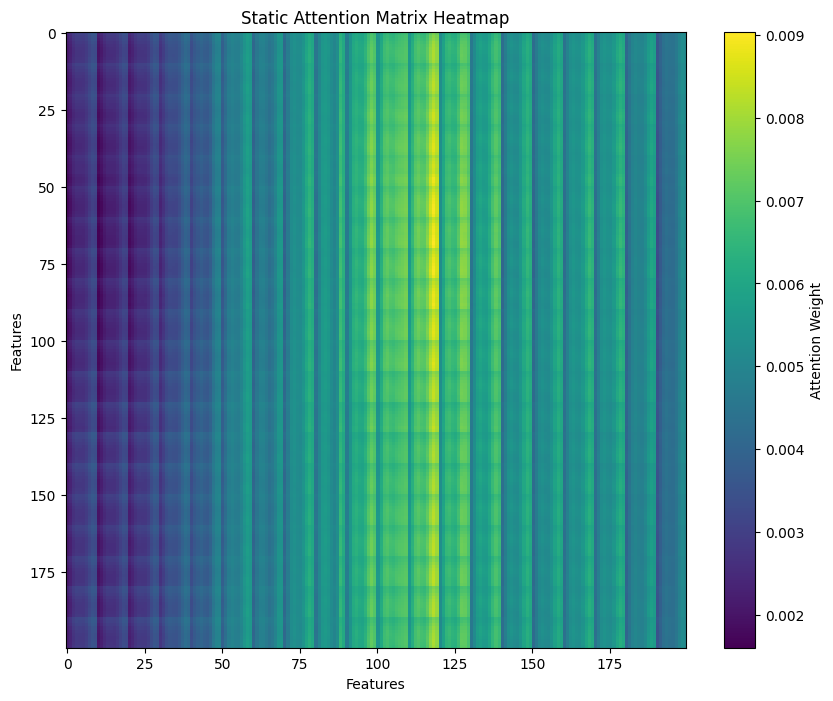

In [147]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = VisionTransformer(
        img_size=(args["rows"], args["cols"]),
        patch_size=1,
        in_chans=2,
        embed_dim=64,
        predictor_embed_dim=None,
        depth=1,
        predictor_depth=None,
        num_heads=1,
        mlp_ratio=4,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.2,
        drop_path_rate=0.1,
        norm_layer=torch.nn.LayerNorm,
        init_std=0.02
    )
predictor = VisionTransformerPredictor(
    img_size=(args["rows"], args["cols"]),
    embed_dim=64,
    predictor_embed_dim=64//2,
    depth=1,
    num_heads=1,
    mlp_ratio=4,
    qkv_bias=True,
    qk_scale=None,
    drop_rate=0.0,
    attn_drop_rate=0.2,
    drop_path_rate=0.1,
    norm_layer=torch.nn.LayerNorm,
    init_std=0.02
)

import copy
target_encoder = copy.deepcopy(encoder)


load_path = r"D:\omer\ST-SSL\logs\singleBLK_try2\jepa-ep30.pth.tar"

if load_model:
    encoder, predictor, target_encoder, optimizer, scaler, start_epoch = load_checkpoint(
        device=device,
        r_path=load_path,
        encoder=encoder,
        predictor=predictor,
        target_encoder=target_encoder,
        opt=optimizer,
        scaler=scaler)
    for _ in range(start_epoch*ipe):
        scheduler.step()
        wd_scheduler.step()

        # next(momentum_scheduler)
## just get the attention maps from the context_encoder (input whole image)
encoder.eval().to(device)
predictor.eval().to(device)
target_encoder.eval().to(device)
with torch.no_grad():
    for i, (data, _) in enumerate(val_loader):
        data = data[:, 0, :, :].squeeze(1)
        B, N, D = data.size()
        data = data.view(B, args["rows"], args["cols"], D).to(device)
        imgs, masks_enc, masks_pred = generateMasks(data)
        imgs = imgs.permute(0, 3, 1, 2)  # [B, D, R, C]
        masks_pred = masks_pred.flatten(2)  # [B, 4, R*C]
        masks_enc = masks_enc.flatten(1).unsqueeze(1)  # [B, 1, R*C]
        
        """ see whole image as context """
        masks_enc=torch.ones_like(masks_enc)
        # masks_enc=torch.zeros_like(masks_enc)
        # masks_enc[:, :, 0:2] = 1
        def forward_context():    ## mask context tokens before encoding
            z, attn_list = encoder(imgs, masks=masks_enc)  ## VisionTransformer
            return z, attn_list
        
        z, attn_list_1 = forward_context()  # Context encoder forward pass
        


import matplotlib.pyplot as plt

# Generate the same 200x200 attention matrix
np.random.seed(42)
attn1 = attn_list_1[0][0].squeeze(0).softmax(-1).cpu().numpy()[:,:]

# Create a static heatmap using Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(attn1, cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Weight')
plt.title('Static Attention Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()


In [150]:
attn1.shape

# np.savez(r'D:\omer\ST-SSL\data\NYCTaxi\pretrained_adj_mx.npz', attn1=attn1)


In [119]:
attn_list1 = [attn_list_1[i][0].squeeze(0).detach().cpu().softmax(-1).numpy() for i in range(6)]

attn_array = np.array(attn_list1)
average_attention = np.mean(attn_array, axis=0)


In [18]:
# import numpy as np



# print("Average Matrix:", average_attention)


In [19]:
# attn1 = attn_list[1][0].squeeze(0)
# avg_attn = attn1
# for i in range(1, len(attn_list)): avg_attn+=attn_list[i][0].squeeze(0)
# avg_attn = avg_attn/len(attn_list)

